# Autocodificador sin reducción de dimensionalidad explicita

El siguiente autocodificador se creo bajo la idea de reducir la dimensionalidad para una  base de datos de alta dimensión, a diferencia de un autocodificador tradicional en el cual se van reduciendo el número de neuronas gradualmente a manera de "embudo" la arquitectura de esté autocodifacodr tiene un cambio pequeño pero significativo.

Cuando en un autocodificador clásico se llega a la representación latente más comprimida la dimensión de este vector latente es igual al número de neuronas del espacio latente, tipicamnete la dimensión latente es más pequeña que la dimensión de los datos de entrada así logrando reducir la dimensión de los datos, está representación latente se encuentra en la mitad de nuestro autocodificador y dependiendo del tipo de datos de entrada se seleccionan las funciones de costo, las cuales son normalmente una de regularización y de reconstrucción, ya que el objetivo al construir un autocodificador es lograr reproducir los datos de entrada.

En este autocodificador tenemos  un espacio latente de la misma dimensión que los datos de entrada, lo cual no tendría sentido ya que no se está reduciendo la dimensionalidad pero añadimos un término de regularización a la función de costo el cual es la norma L2 de el vector latente para de esta fortma lograr que la salida de algunas neuronas se acerque o se haga cero, de esta manera se lográ reducir la dimensionalidad de manera implicita ya que auqellas  neuronas que esten cerca del cero o sean cero, podemos considerarlas como si no estuvieran ahí (ya que no aportan información significativa a la representación latente) por lo que podemos "cortarlas", de esta manera reduciendo las dimensiones de la información de entrada.

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import entropy
from  scipy.special import  kl_div
import tensorflow_probability as tfp

2025-10-24 18:01:49.855718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("GPUS disponibles", tf.config.list_physical_devices('GPU'))

GPUS disponibles [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
data = pd.read_csv('Liver_GSE14520_U133A.csv')
data.head()


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM362958.CEL.gz,HCC,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,GSM362959.CEL.gz,HCC,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,GSM362960.CEL.gz,HCC,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,GSM362964.CEL.gz,HCC,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,GSM362965.CEL.gz,HCC,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


In [5]:
data.drop(['samples','type'], axis=1, inplace=True)
data.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,3.654116,3.804983,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,5.137159,8.622475,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,4.515175,12.681439,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,5.192624,11.759412,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,4.961625,10.318552,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


In [6]:
# Normalización de los datos
data = data.values.astype(np.float32)
data = StandardScaler().fit_transform(data)

In [7]:
# Hiperparametros de la red
input_dim = data.shape[1]
latent_dim = input_dim
learning_rate = 0.00005
l1_norm_weight = 1e-5
recon_weight = 1
negative_slope = 0.1
mini_batch_size = 51
epochs=100

In [8]:
# encoder
input_layer = keras.Input(shape=(input_dim,))
latent_space = layers.Dense(input_dim, name="latent_space")(input_layer)
latent_space =  LeakyReLU(negative_slope)(latent_space)

I0000 00:00:1761328918.402767     444 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [9]:
encoder = keras.Model(input_layer, latent_space, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 22277)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 22277)          │   496,287,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 22277)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,287,006 (1.85 GB)

 Trainable params: 496,287,006 (1.85 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# decoder
latent_input = keras.Input(shape=(input_dim,), name="decoder_input")
reconstruction = layers.Dense(input_dim, name="decoder_output")(latent_input)
reconstruction = layers.LeakyReLU(negative_slope)(reconstruction)

In [11]:
decoder = keras.Model(latent_input, reconstruction, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 22277)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 22277)          │   496,287,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 22277)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,287,006 (1.85 GB)

 Trainable params: 496,287,006 (1.85 GB)

 Non-trainable params: 0 (0.00 B)

In [12]:
class Autoencoder(keras.Model):
  def __init__(self, encoder, decoder, l1_norm_weight, recon_weight, **kwargs):
    super(Autoencoder, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.l1_norm_weight = l1_norm_weight
    self.recon_weight = recon_weight
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.l1_norm_loss_tracker = keras.metrics.Mean(name="l1_norm_loss")

  def call(self, inputs):
      encoded = self.encoder(inputs)
      decoded = self.decoder(encoded)
      return decoded

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.l1_norm_loss_tracker,
    ]

  def train_step(self, data):
    if isinstance(data, tuple):
        data = data[0]

    with tf.GradientTape() as tape:
        latent_rep = self.encoder(data)
        l1_norm_loss = tf.reduce_sum(tf.abs(latent_rep))*self.l1_norm_weight
        x_reconstructed = self.decoder(latent_rep)
        reconstruction_loss = tf.reduce_mean(
                    tf.square(data - x_reconstructed)
                )*self.recon_weight

        total_loss = l1_norm_loss + reconstruction_loss
    grads =  tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.l1_norm_loss_tracker.update_state(l1_norm_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "l1_norm_loss": self.l1_norm_loss_tracker.result(),
    }







In [13]:
#implementar un dataset de tensorflow
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size=357).batch(mini_batch_size)

In [14]:
autoencoder = Autoencoder(encoder, decoder, l1_norm_weight, recon_weight)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate))
history = autoencoder.fit(dataset, epochs=epochs)

Epoch 1/100


2025-10-24 18:02:03.244103: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c92a4005a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 18:02:03.244137: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-10-24 18:02:03.302178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-24 18:02:03.378559: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-24 18:02:03.837471: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_236', 4 bytes spill stores, 4 bytes spill loads

2025-10-24 18:02:04.136478: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas war

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - l1_norm_loss: 4.5867 - loss: 5.7390 - reconstruction_loss: 1.1523

I0000 00:00:1761328926.265952     592 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - l1_norm_loss: 4.3357 - loss: 5.4037 - reconstruction_loss: 1.0680
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - l1_norm_loss: 3.4332 - loss: 4.4360 - reconstruction_loss: 1.0027
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - l1_norm_loss: 2.9993 - loss: 3.9912 - reconstruction_loss: 0.9919
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - l1_norm_loss: 2.6583 - loss: 3.6403 - reconstruction_loss: 0.9820
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - l1_norm_loss: 2.3778 - loss: 3.3448 - reconstruction_loss: 0.9670
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - l1_norm_loss: 2.1396 - loss: 3.0923 - reconstruction_loss: 0.9527
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - l1_norm_loss: 1.9316 - loss: 2.8665 - reconstruction_loss: 0.9349
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - l1_norm_loss: 1.7458 - loss: 2.6574 - reconstruction_loss: 0.9115
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - l1_norm_loss: 1

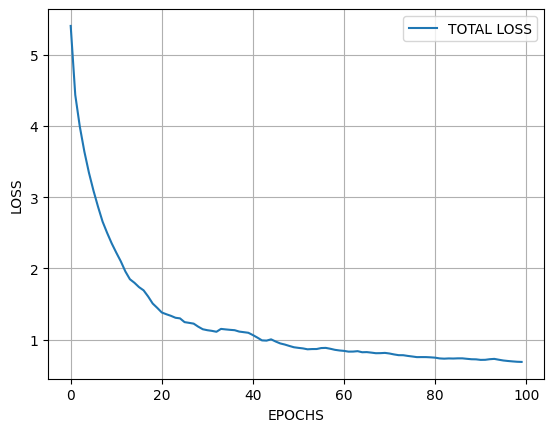

In [15]:
plt.plot(history.history['loss'], label='TOTAL LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.grid(True)
plt.show()


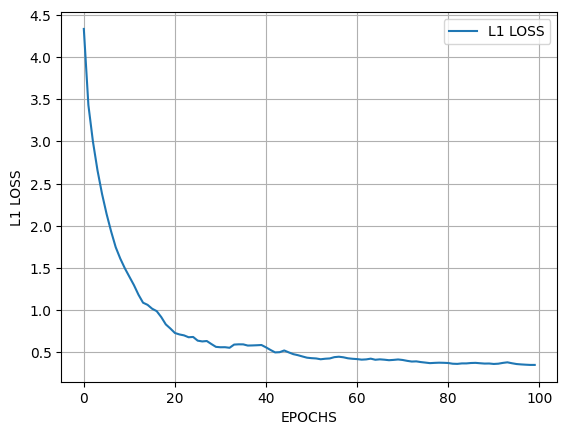

In [16]:
plt.plot(history.history['l1_norm_loss'], label='L1 LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('L1 LOSS')
plt.legend()
plt.grid(True)
plt.show()

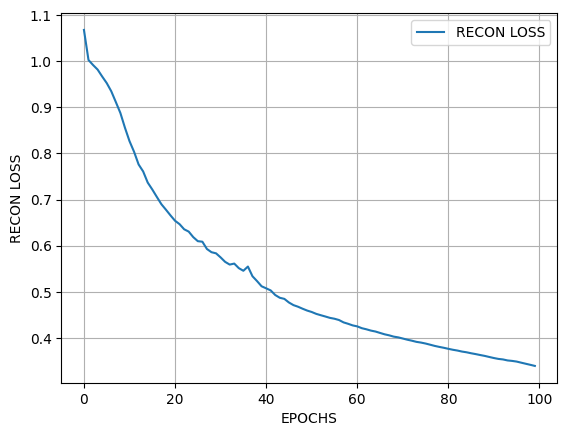

In [17]:
plt.plot(history.history['reconstruction_loss'], label='RECON LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('RECON LOSS')
plt.legend()
plt.grid(True)
plt.show()

## Ajuste de Modelos Probabilisticos 

Para el analisis de la entropia relativa entre los datos originales y los datos latentes se propone que se ajusten dos distribuciones  de probabilidad a estos datos mediante dos modelos sencillos implementados con la librería Tensorflow Probability.

En un modelo de regresión buscamos ajustar una distribución de densidad de probabilidad condicional, una red probabilistica aprende esta distribución calculando sus parametros.

El autoencoder tiene un objetivo parecido pero diferente ya que no buscamos predecir un dato sino ue se busca reconstruir el dato de entrada original. En nuestro caso buscamos describir la estructura estadistica de los datos en el espacio original y latente para despues compararlas mediante el calculo de la Divergencia KL. La estructura original tiene una distribución de probabilidad empirica donde puede haber por ejemplo caracteristicas que solo introduzcan ruido ya que sus distribución de probabilidad es uniforme y por lo tanto aporta poca información o caracteristicas altamente correlacionadas por lo que un par o más de estas caracteristicas aportan la misma información.

El objetivo del encoder es que mediante minimzar la norma L1 sse reorganicen las caracteristicas que si aportan información y filtrar las que no son relevantes. La forma en la que se obtendran loss parametros de ambas distribuciones seran mediante dos modeloss:

- Uno que reciba los datos originales como entrada y de salida obtengamos los parametros de la distribución original.
- Uno que recibe los datos codificados en el espacio latente y su salida sean los datos de la distribución latente.

Para ajustar el espacio original utilizaremos una distribución multimodal de Gaussinas y para el latente usaremos distribuciones de Laplace.

In [ ]:
## Ajuste para datos originales

# distros

tfd = tfp.distributions
tfpl = tfp.layers

#


# Analisis de las entropias

Uno de los objetivos al agregar una norma L1 como termino en la función de costo fue lograr que la reducción de dimensionalidad no fuera explicita, esto nos permite visualizar que columnas o dimensiones de nuestra base de datos son más o menos informativas, lo cual nos permite distinguir en cuales son más o menos útiles a considerar para el problema que estemos abordando.

En este caso estamos usando nuestro autocodificador en una base de datos de expresión génica para cancer de higado, que contiene aproximadamente 22000 columnas (genes), de las cuales no podriamos saber a simple vista cuales considerar para la clasificación de el tipo de cancer sin antes hacer por ejemplo un analisis de componentes principales, el entrenar una red neuronal como un autocodificador se presenta como una alternativa para obtener este tipo de resultados con un modelo de Deep Learning.

Para analizar que componentes aportan más o menos información nos valdremos de una cantidad llamada Entropía de la Información o Entropía de Shannon, en este analisis nos concentraremos primero en ver la entropia por dimensión, es decir, vamos a caracterizar cada gen con esta cantidad y a partir de esta veremos que columnas contienen más información relevante para la detección. De este modo los datos originales tendrán una entropia inicial y despues al pasar por el codificador nuestra red aprenderá una representación comprimida de los datos lo cual en principio deberia reducir la entropia de los mismos.

De los graficos se púede ver que efectivamente se ha logrado una reduccón de entropia en la representanción latente, esto quiere decir que nuestra red neuronal esta filtrando la información que es o no relevante para la clasificación, en este caso una columna (gen) con alta entropia tiene una expresión genica muy variada (distribución de probabilidad pareja) por lo que no aporta mucha información a la predicción mientras que  un gen que tiene baja entropia tiene una expresión genica más predecible por lo que su patron podria estar relacionado con el tipo de cancer (aporta más información a la clasificación), al reducirse esta entropia en el espacio latente estamos logrando que la red aprenda estos patrones relevantes en la información para los genes que los contienen.